# Data Modelarion
## Import Libraries

In [201]:
import pandas as pd 
import numpy as np 
import scipy as sp 
import re
from unidecode import unidecode

import matplotlib.pyplot as plt
import seaborn as sns

# one hot encoding con feature-engine
#from feature_engine.encoding import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# GroupKFold en un pipeline con StandardScaler y SVC
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate, GroupKFold, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

## Import Data

In [216]:
X_train= pd.read_csv('../datasets/processed/X_train.csv', sep=',', encoding='utf-8')
X_test= pd.read_csv('../datasets/processed/X_test.csv', sep=',', encoding='utf-8')
y_test= pd.read_csv('../datasets/processed/y_test.csv', sep=',', encoding='utf-8')
y_train= pd.read_csv('../datasets/processed/y_train.csv', sep=',', encoding='utf-8')

In [217]:
# Verificar las formas de los conjuntos resultantes
print("Shapes of training sets:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nShapes of testing sets:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Shapes of training sets:
X_train: (454, 53)
y_train: (454, 1)

Shapes of testing sets:
X_test: (114, 53)
y_test: (114, 1)


Shapes of training sets:
X_train: (454, 53)
y_train: (454, 1)

Shapes of testing sets:
X_test: (114, 53)
y_test: (114, 1)
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 64, 'min_samples_split': 32}


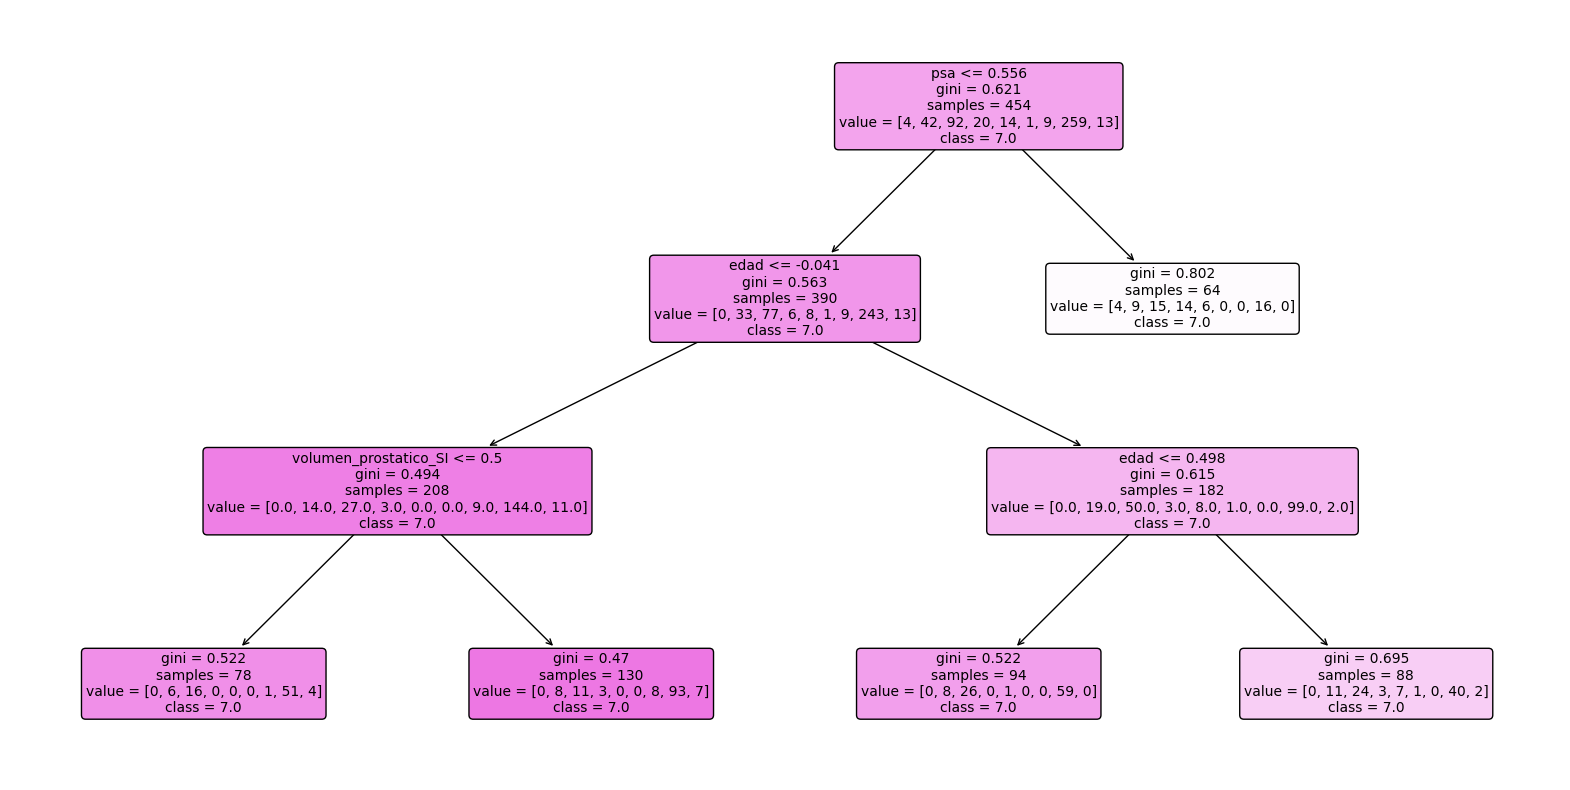

In [160]:
# Verificar las formas de los conjuntos resultantes
print("Shapes of training sets:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nShapes of testing sets:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
# Configuración de semilla
SEED = 301
np.random.seed(SEED)

# Función para entrenar un árbol de decisión y realizar la validación cruzada
def train_and_cross_validate_decision_tree(X_train, y_train, max_depth, min_samples_leaf=None):
    cv = StratifiedKFold(n_splits=10)
    if min_samples_leaf:
        modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=SEED)
    else:
        modelo = DecisionTreeClassifier(max_depth=max_depth, random_state=SEED)

    results = cross_validate(modelo, X_train, y_train, cv=cv, return_train_score=True)
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    print('Árbol max_depth = %d, min_samples_leaf = %s, training = %.2f, testing = %.2f' % (max_depth, str(min_samples_leaf), train_score, test_score))
    return max_depth, min_samples_leaf, train_score, test_score

# Función para realizar búsqueda de hiperparámetros
def hyperparameter_search(X_train, y_train):
    espacio_de_parametros = {
        'max_depth': [3, 5],
        'min_samples_split': [32, 64, 128],
        'min_samples_leaf': [32, 64, 128],
        'criterion': ['gini', 'entropy']
    }

    buscar = GridSearchCV(DecisionTreeClassifier(random_state=SEED),
                          espacio_de_parametros,
                          cv=KFold(n_splits=5, shuffle=True))

    buscar.fit(X_train, y_train)
    resultados = pd.DataFrame(buscar.cv_results_)
    return resultados, buscar.best_params_

# Función para visualizar el árbol de decisión
# Función para visualizar el árbol de decisión
def visualize_tree(model, features, class_names=None):
    plt.figure(figsize=(20, 10))
    plot_tree(model, filled=True, rounded=True, class_names=class_names, feature_names=features)
    plt.savefig('../datasets/images/tree.png')

# Realizar búsqueda de hiperparámetros
resultados_hyperparametros, mejores_hiperparametros = hyperparameter_search(X_train, y_train)

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros:", mejores_hiperparametros)

# Entrenar el modelo con los mejores hiperparámetros
mejor_modelo = DecisionTreeClassifier(**mejores_hiperparametros, random_state=SEED)
mejor_modelo.fit(X_train, y_train)

# Visualizar el árbol de decisión con los mejores hiperparámetros
visualize_tree(mejor_modelo, X_train.columns, class_names=[str(i) for i in mejor_modelo.classes_])


In [94]:
print("Clases del modelo:", mejor_modelo.classes_)

Clases del modelo: [0. 1. 2. 3. 4. 5. 6. 7. 8.]


In [101]:
type(y_train)

pandas.core.frame.DataFrame

In [190]:
# Verificar el balance de clases en los conjuntos de entrenamiento y prueba
print("Distribución de clases en y_train:")
if len(y_train) > 0:
    print(pd.Series(y_train.values.flatten()).value_counts())
else:
    print("El conjunto de entrenamiento está vacío.")

print("\nDistribución de clases en y_test:")
if len(y_test) > 0:
    print(pd.Series(y_test.values.flatten()).value_counts())
else:
    print("El conjunto de prueba está vacío.")

Distribución de clases en y_train:
7.0    259
2.0     92
1.0     42
3.0     20
4.0     14
8.0     13
6.0      9
0.0      4
5.0      1
Name: count, dtype: int64

Distribución de clases en y_test:
7.0    63
2.0    24
1.0    12
4.0     6
6.0     5
3.0     2
5.0     1
8.0     1
Name: count, dtype: int64


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline


In [192]:
from imblearn.over_sampling import RandomOverSampler

# Especificar la proporción deseada para cada clase
sampling_strategy = {
    0.0: 9,  
    1.0: 47,
    2.0: 97,
    3.0: 25,
    4.0: 19,
    5.0: 6,
    6.0: 13,
    7.0: 259,
    8.0: 13  # Ajusta esta proporción para que sea mayor o igual al número original (13)
}
# Crear un objeto RandomOverSampler con la proporción especificada
oversampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=SEED)

# Aplicar oversampling a los conjuntos de entrenamiento
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Verificar las formas después del oversampling
print("Shapes after oversampling:")
print("X_train_resampled:", X_train_resampled.shape)
print("y_train_resampled:", y_train_resampled.shape)

# Verificar la distribución de clases después del oversampling
print("Distribución de clases en y_train_resampled:")
print(y_train_resampled['biopsia'].value_counts())


Shapes after oversampling:
X_train_resampled: (488, 53)
y_train_resampled: (488, 1)
Distribución de clases en y_train_resampled:
biopsia
7.0    259
2.0     97
1.0     47
3.0     25
4.0     19
8.0     13
6.0     13
0.0      9
5.0      6
Name: count, dtype: int64


Registros originales:
       edad       psa  numero_de_muestras_tomadas  dias_hospitalizacion_mq  \
0 -0.742132  0.078757                   -0.254351                -0.172889   
1  0.012720 -0.312913                   -0.254351                -0.172889   
2  0.659736 -0.171245                   -0.254351                -0.172889   
3 -0.418624 -0.468043                   -0.254351                -0.172889   
4 -0.095116 -0.177656                   -0.254351                -0.172889   

   dias_hospitalizacion_upc  diabetes  hospitalizacion_ultimo_mes  cup  \
0                  -0.07175       0.0                         0.0  0.0   
1                  -0.07175       0.0                         0.0  0.0   
2                  -0.07175       0.0                         0.0  0.0   
3                  -0.07175       0.0                         0.0  0.0   
4                  -0.07175       0.0                         0.0  0.0   

   diabetes_NO  diabetes_SI  ...  agente_aislado_nan  \
0       

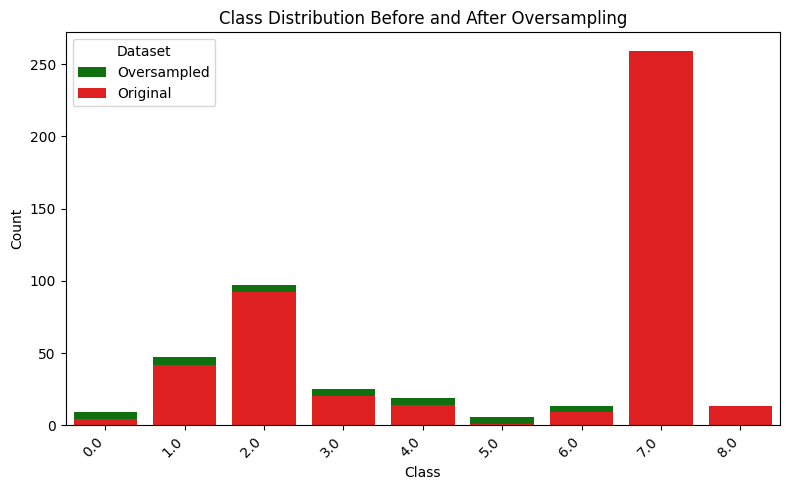

In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler


# Asumiendo que ya has cargado X_train, y_train, X_test, y_test

# Especificar la proporción deseada para cada clase
sampling_strategy = {
    0.0: 9,
    1.0: 47,
    2.0: 97,
    3.0: 25,
    4.0: 19,
    5.0: 6,
    6.0: 13,
    7.0: 259,
    8.0: 13  # Ajusta esta proporción para que sea mayor o igual al número original (13)
}

# Crear un objeto RandomOverSampler con la proporción especificada
oversampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=SEED)

# Aplicar oversampling a los conjuntos de entrenamiento
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Mostrar algunos registros originales
df_original = pd.concat([X_train, y_train], axis=1)
print("Registros originales:")
print(df_original.head())

# Mostrar algunos registros sobremuestreados
df_oversampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)
print("\nRegistros sobremuestreados:")
print(df_oversampled.head())

# Restaurar el índice si es necesario
df_original.reset_index(drop=True, inplace=True)
df_oversampled.reset_index(drop=True, inplace=True)


# Plot the bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x='Class', y='Oversampled', data=data, color='green', label='Oversampled')
sns.barplot(x='Class', y='Original', data=data, color='red', label='Original')

# Add plot details
plt.title('Class Distribution Before and After Oversampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend(title='Dataset')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Save the plot
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()


Registros originales:
       edad       psa  numero_de_muestras_tomadas  dias_hospitalizacion_mq  \
0 -0.742132  0.078757                   -0.254351                -0.172889   
1  0.012720 -0.312913                   -0.254351                -0.172889   
2  0.659736 -0.171245                   -0.254351                -0.172889   
3 -0.418624 -0.468043                   -0.254351                -0.172889   
4 -0.095116 -0.177656                   -0.254351                -0.172889   

   dias_hospitalizacion_upc  diabetes  hospitalizacion_ultimo_mes  cup  \
0                  -0.07175       0.0                         0.0  0.0   
1                  -0.07175       0.0                         0.0  0.0   
2                  -0.07175       0.0                         0.0  0.0   
3                  -0.07175       0.0                         0.0  0.0   
4                  -0.07175       0.0                         0.0  0.0   

   diabetes_NO  diabetes_SI  ...  agente_aislado_nan  \
0       

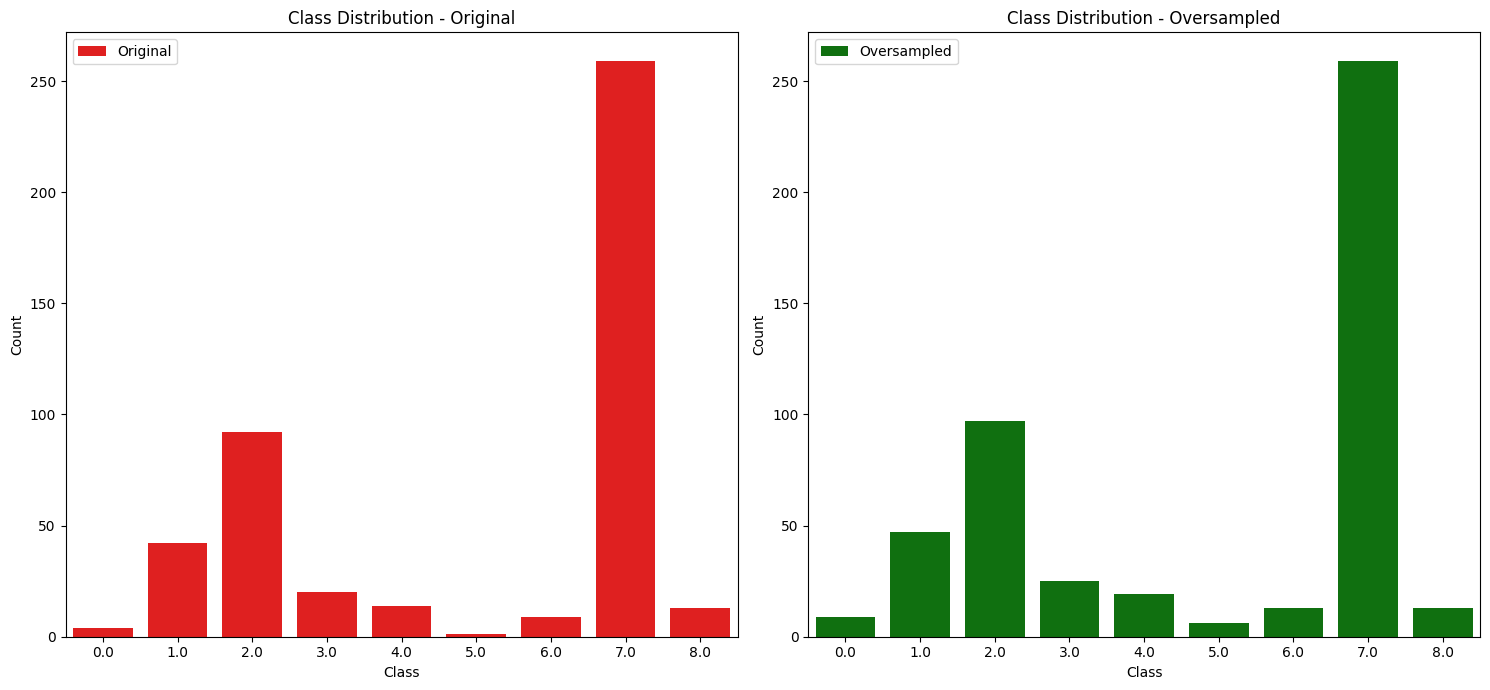

In [210]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline

# Asumiendo que ya has cargado X_train, y_train, X_test, y_test
# y que has definido SEED

# Especificar la proporción deseada para cada clase
sampling_strategy = {
    0.0: 9,
    1.0: 47,
    2.0: 97,
    3.0: 25,
    4.0: 19,
    5.0: 6,
    6.0: 13,
    7.0: 259,
    8.0: 13  # Ajusta esta proporción para que sea mayor o igual al número original (13)
}

# Crear un objeto RandomOverSampler con la proporción especificada
oversampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=SEED)

# Aplicar oversampling a los conjuntos de entrenamiento
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Mostrar algunos registros originales
df_original = pd.concat([X_train, y_train], axis=1)
print("Registros originales:")
print(df_original.head())

# Mostrar algunos registros sobremuestreados
df_oversampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)
print("\nRegistros sobremuestreados:")
print(df_oversampled.head())

# Restaurar el índice si es necesario
df_original.reset_index(drop=True, inplace=True)
df_oversampled.reset_index(drop=True, inplace=True)

# Crear gráficos uno al lado del otro
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Gráfico izquierdo - Original
sns.barplot(x='Class', y='Original', data=data, color='red', label='Original', ax=axs[0])
axs[0].set_title('Class Distribution - Original')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Count')

# Gráfico derecho - Oversampled
sns.barplot(x='Class', y='Oversampled', data=data, color='green', label='Oversampled', ax=axs[1])
axs[1].set_title('Class Distribution - Oversampled')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Count')

# Ajustar diseño
plt.tight_layout()
plt.show()


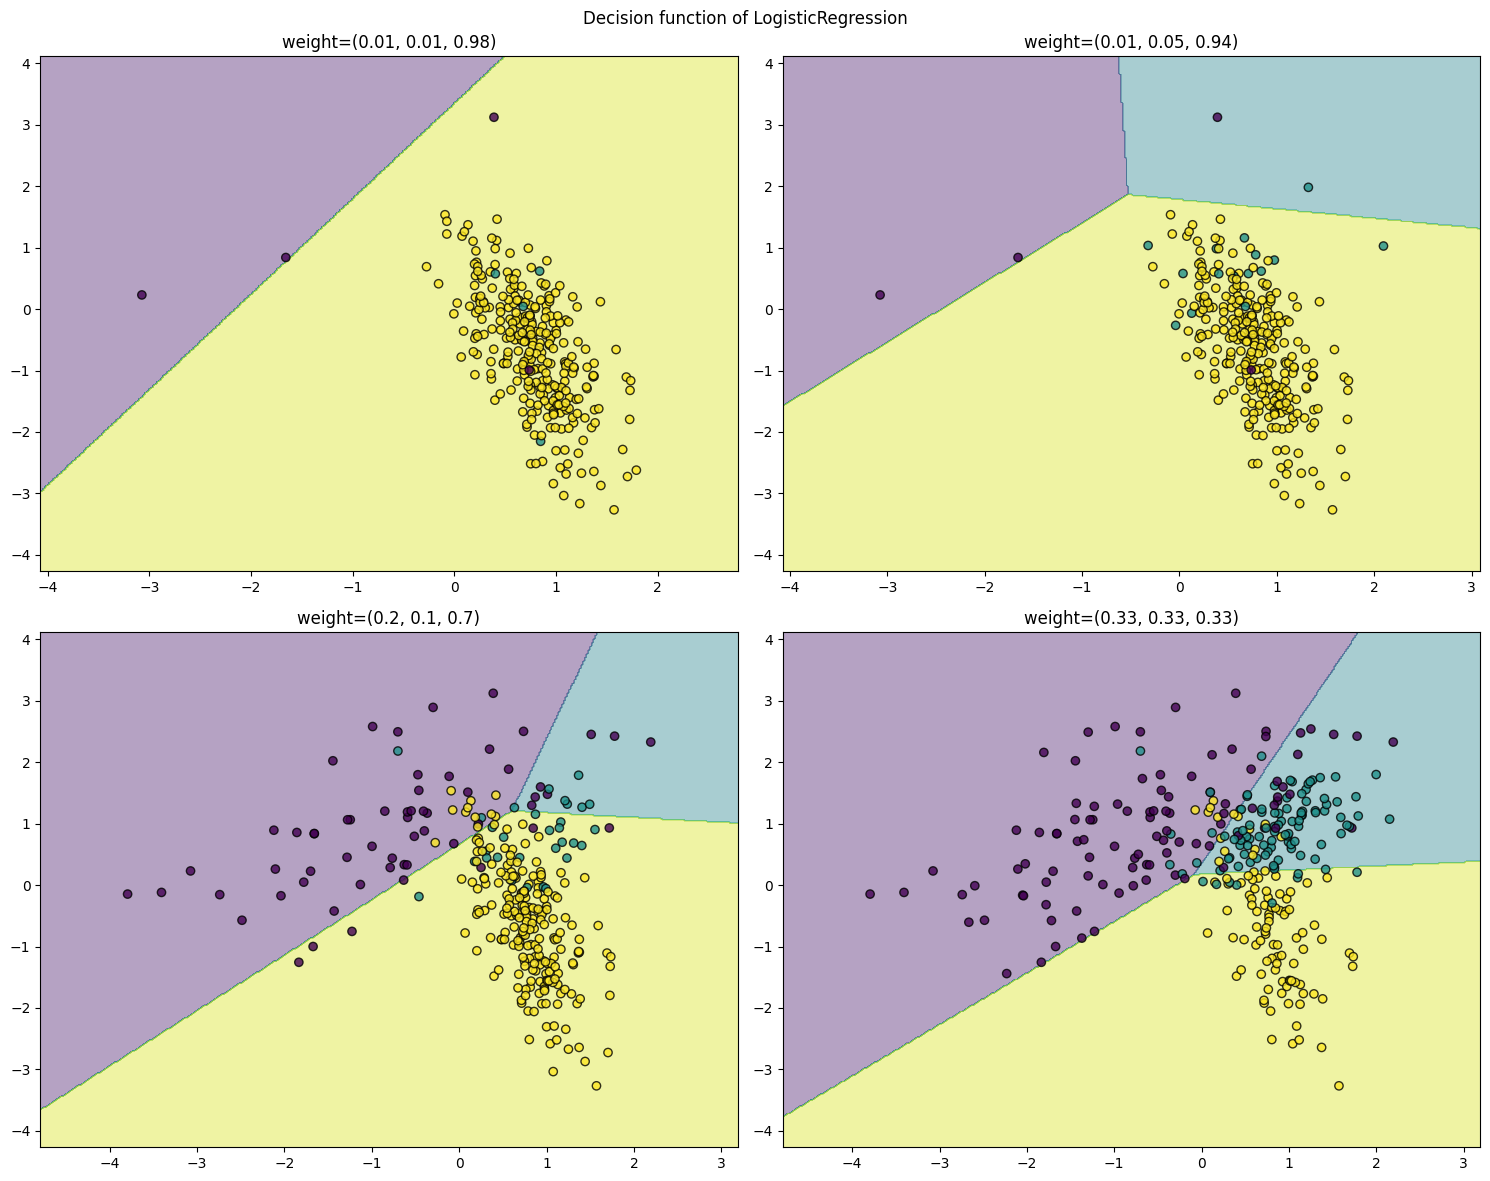

In [213]:
from sklearn.datasets import make_classification


def create_dataset(
    n_samples=1000,
    weights=(0.01, 0.01, 0.98),
    n_classes=3,
    class_sep=0.8,
    n_clusters=1,
):
    return make_classification(
        n_samples=n_samples,
        n_features=2,
        n_informative=2,
        n_redundant=0,
        n_repeated=0,
        n_classes=n_classes,
        n_clusters_per_class=n_clusters,
        weights=list(weights),
        class_sep=class_sep,
        random_state=0,
    )
def plot_resampling(X, y, sampler, ax, title=None):
    X_res, y_res = sampler.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor="k")
    if title is None:
        title = f"Resampling with {sampler.__class__.__name__}"
    ax.set_title(title)
    sns.despine(ax=ax, offset=10)
import numpy as np


def plot_decision_function(X, y, clf, ax, title=None):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor="k")
    if title is not None:
        ax.set_title(title)
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

weights_arr = (
    (0.01, 0.01, 0.98),
    (0.01, 0.05, 0.94),
    (0.2, 0.1, 0.7),
    (0.33, 0.33, 0.33),
)
for ax, weights in zip(axs.ravel(), weights_arr):
    X, y = create_dataset(n_samples=300, weights=weights)
    clf.fit(X, y)
    plot_decision_function(X, y, clf, ax, title=f"weight={weights}")
    fig.suptitle(f"Decision function of {clf.__class__.__name__}")
fig.tight_layout()



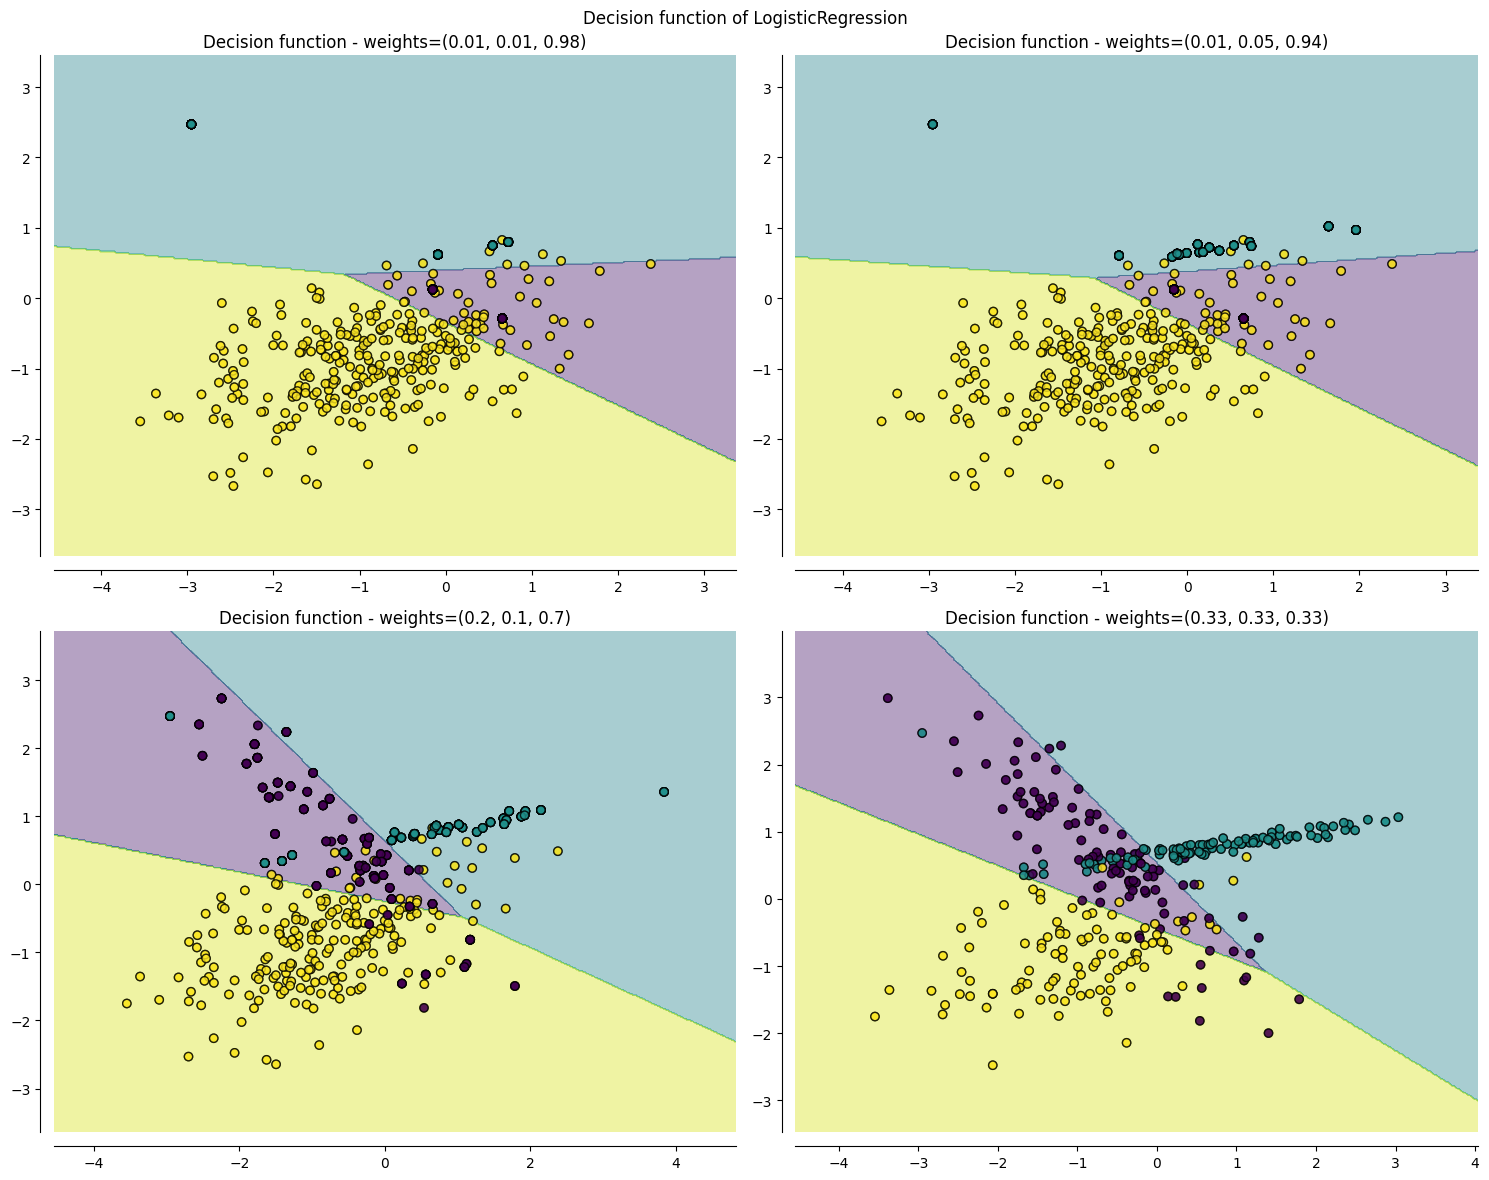

In [214]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
X=X_train
y=y_train
# Crear un conjunto de datos desbalanceado similar a tu caso
def create_dataset(
    n_samples=1000,
    weights=(0.01, 0.01, 0.98),
    n_classes=3,
    class_sep=0.8,
    n_clusters=1,
    random_state=None
):
    return make_classification(
        n_samples=n_samples,
        n_features=2,
        n_informative=2,
        n_redundant=0,
        n_repeated=0,
        n_classes=n_classes,
        n_clusters_per_class=n_clusters,
        weights=list(weights),
        class_sep=class_sep,
        random_state=random_state,
    )

# Función para visualizar el resampling
def plot_resampling(X, y, sampler, ax, title=None):
    X_res, y_res = sampler.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor="k")
    if title is None:
        title = f"Resampling with {sampler.__class__.__name__}"
    ax.set_title(title)
    sns.despine(ax=ax, offset=10)

# Crear un clasificador logistic
clf = LogisticRegression()

# Crear conjuntos de subgráficos
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

weights_arr = (
    (0.01, 0.01, 0.98),
    (0.01, 0.05, 0.94),
    (0.2, 0.1, 0.7),
    (0.33, 0.33, 0.33),
)

for ax, weights in zip(axs.ravel(), weights_arr):
    # Crear un conjunto de datos desbalanceado
    X, y = create_dataset(n_samples=300, weights=weights, random_state=SEED)
    
    # Aplicar oversampling al conjunto de datos
    oversampler = RandomOverSampler(sampling_strategy='auto', random_state=SEED)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    
    # Entrenar el clasificador con el conjunto de datos balanceado
    clf.fit(X_resampled, y_resampled)
    
    # Visualizar el resampling y la decisión del clasificador
    plot_resampling(X, y, oversampler, ax, title=f"Resampling - weights={weights}")
    plot_decision_function(X_resampled, y_resampled, clf, ax, title=f"Decision function - weights={weights}")

fig.suptitle(f"Decision function of {clf.__class__.__name__}")
fig.tight_layout()
plt.show()


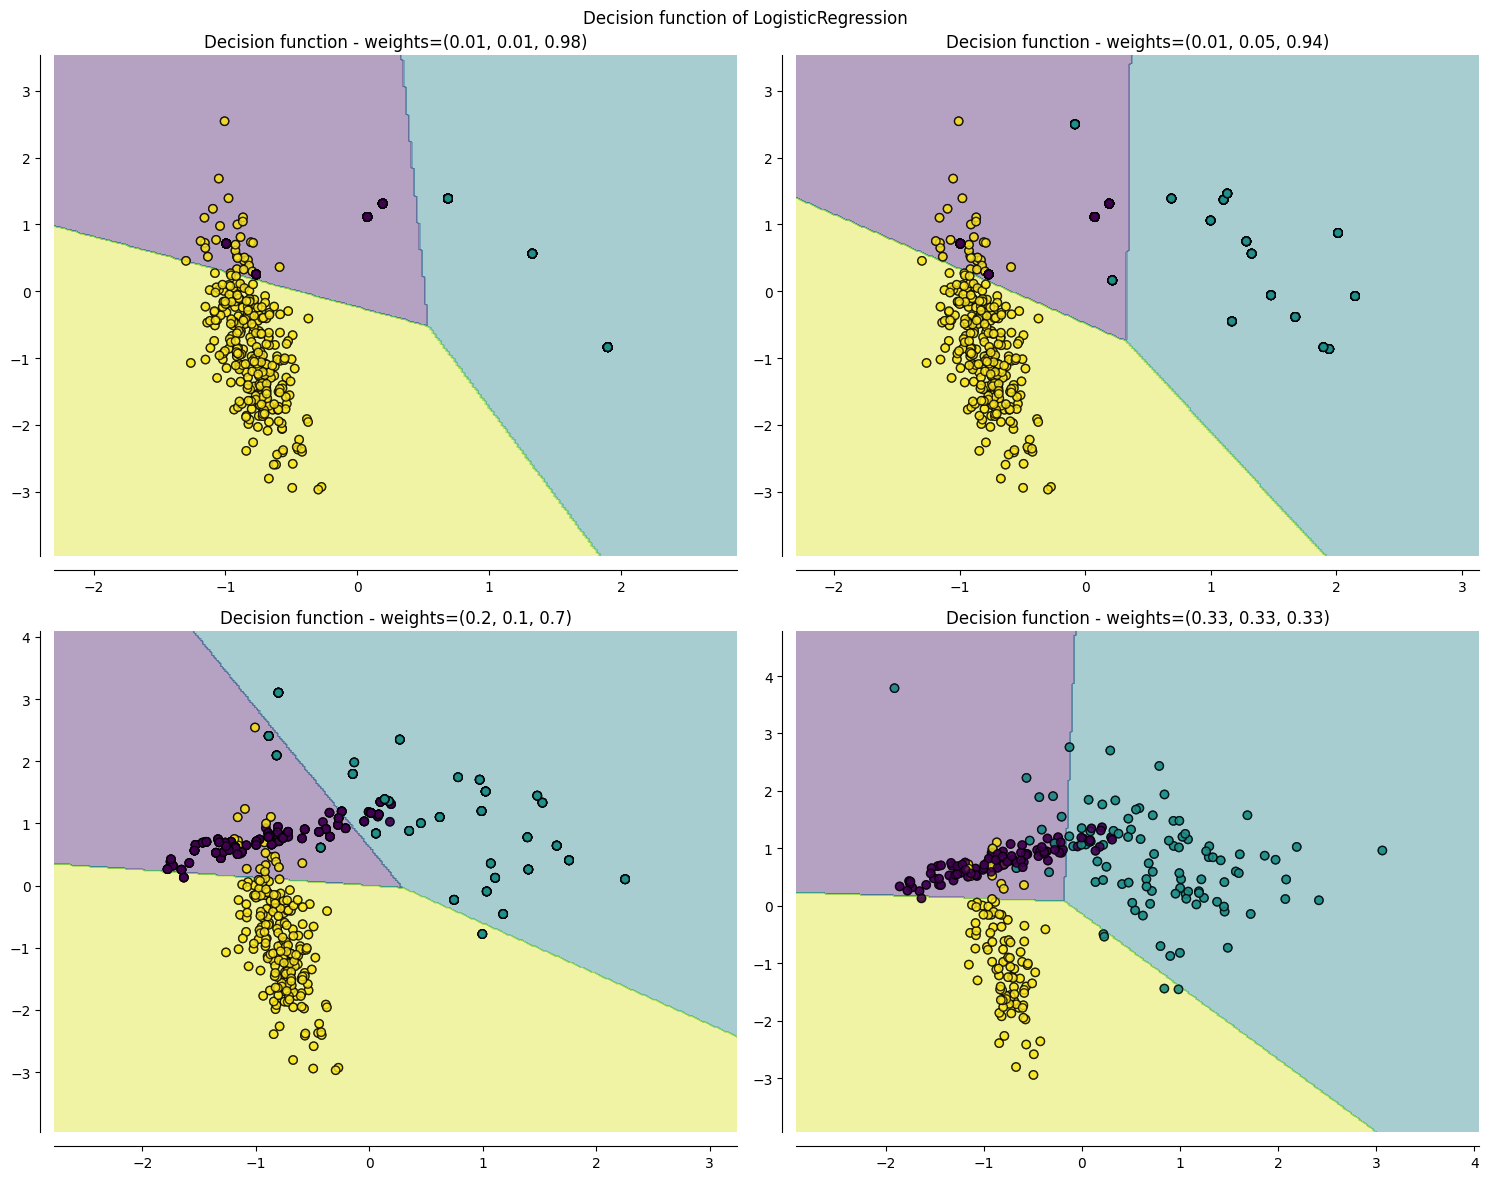

Shapes after oversampling:
X_train_resampled: (300, 2)
y_train_resampled: (300,)
Distribución de clases en y_train_resampled:
2    293
0    293
1    293
Name: count, dtype: int64


In [249]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# Seed para reproducibilidad
SEED = 42

# Crear un conjunto de datos desbalanceado similar a tu caso
def create_dataset(
    n_samples=1000,
    weights=(0.01, 0.01, 0.98),
    n_classes=3,
    class_sep=0.8,
    n_clusters=1,
    random_state=None
):
    return make_classification(
        n_samples=n_samples,
        n_features=2,
        n_informative=2,
        n_redundant=0,
        n_repeated=0,
        n_classes=n_classes,
        n_clusters_per_class=n_clusters,
        weights=list(weights),
        class_sep=class_sep,
        random_state=random_state,
    )

# Función para visualizar la decisión del clasificador
def plot_decision_function(X, y, clf, ax, title=None):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor="k")
    if title is not None:
        ax.set_title(title)

# Crear un clasificador logistic
clf = LogisticRegression()

# Crear conjuntos de subgráficos
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

weights_arr = (
    (0.01, 0.01, 0.98),
    (0.01, 0.05, 0.94),
    (0.2, 0.1, 0.7),
    (0.33, 0.33, 0.33),
)
# Función para visualizar el resampling
def plot_resampling(X, y, sampler, ax, title=None):
    X_res, y_res = sampler.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor="k")
    if title is None:
        title = f"Resampling with {sampler.__class__.__name__}"
    ax.set_title(title)
    sns.despine(ax=ax, offset=10)
# Almacena los conjuntos oversampleados
oversampled_datasets = []

for ax, weights in zip(axs.ravel(), weights_arr):
    # Crear un conjunto de datos desbalanceado
    X, y = create_dataset(n_samples=300, weights=weights, random_state=SEED)
    
    # Aplicar oversampling al conjunto de datos
    oversampler = RandomOverSampler(sampling_strategy='auto', random_state=SEED)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    
    # Almacenar los conjuntos oversampleados
    oversampled_datasets.append((X_resampled, y_resampled))
    
    # Entrenar el clasificador con el conjunto de datos balanceado
    clf.fit(X_resampled, y_resampled)
    
    # Visualizar el resampling y la decisión del clasificador
    plot_resampling(X, y, oversampler, ax, title=f"Resampling - weights={weights}")
    plot_decision_function(X_resampled, y_resampled, clf, ax, title=f"Decision function - weights={weights}")

fig.suptitle(f"Decision function of {clf.__class__.__name__}")
fig.tight_layout()
plt.show()

fig.suptitle(f"Decision function of {clf.__class__.__name__}")
fig.tight_layout()
plt.show()

# Ahora puedes acceder a los conjuntos oversampleados según sea necesario
# Por ejemplo, para el primer conjunto oversampleado

(X_resampled_1, y_resampled_1) = oversampled_datasets[0]

# Verificar las formas después del oversampling
print("Shapes after oversampling:")
print("X_train_resampled:", X_resampled.shape)
print("y_train_resampled:", y_resampled.shape)

# Verificar la distribución de clases después del oversampling
print("Distribución de clases en y_train_resampled:")
print(pd.Series(y_resampled_1).value_counts())

Shapes after oversampling:
X_train_resampled: (300, 53)
y_train_resampled: (300,)


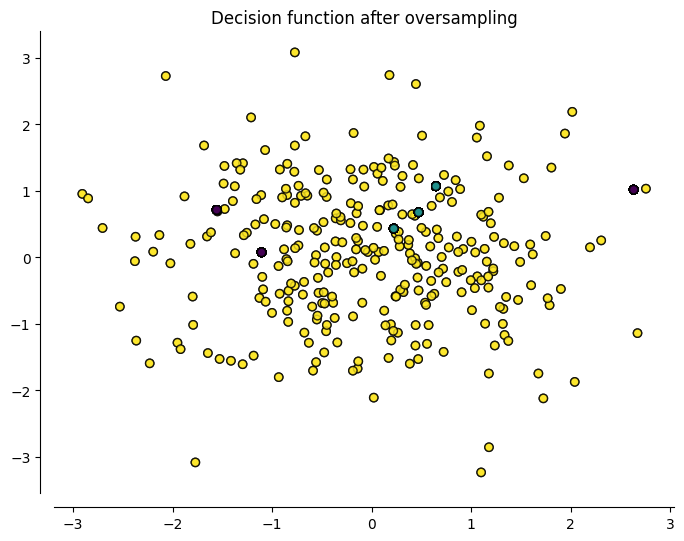

In [258]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# Seed para reproducibilidad
SEED = 42

# Crear un conjunto de datos desbalanceado similar a tu caso
def create_dataset(
    n_samples=1000,
    weights=(0.01, 0.01, 0.98),
    n_classes=3,
    class_sep=0.8,
    n_clusters=1,
    n_features=53,  # Agregamos el parámetro n_features
    random_state=None
):
    return make_classification(
        n_samples=n_samples,
        n_features=n_features,  # Utilizamos el nuevo parámetro
        n_informative=2,
        n_redundant=0,
        n_repeated=0,
        n_classes=n_classes,
        n_clusters_per_class=n_clusters,
        weights=list(weights),
        class_sep=class_sep,
        random_state=random_state,
    )

def plot_decision_function(X, y, clf, ax, title=None):
    plot_step = 0.02

    # Utilizamos solo las dos primeras características del conjunto de datos original
    feature_ranges = [X[:, 0].min() - 1, X[:, 0].max() + 1], [X[:, 1].min() - 1, X[:, 1].max() + 1]
    meshgrid = np.meshgrid(*[np.arange(feature_ranges[0][i], feature_ranges[1][i], plot_step) for i in range(2)])

    # Verificamos que haya al menos una muestra para realizar la predicción
    if np.prod(meshgrid[0].shape) > 0:
        # Modificamos cómo se hace la predicción en la malla
        Z = clf.predict(np.c_[[arr.ravel() for arr in meshgrid]].T)
        Z = Z.reshape(meshgrid[0].shape)

        # Visualiza la decisión del clasificador
        ax.contourf(meshgrid[0], meshgrid[1], Z, alpha=0.4)
    
    # Utilizamos solo las dos primeras características del conjunto de datos original
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor="k")
    
    if title is not None:
        ax.set_title(title)


# Crear un clasificador logistic
clf = LogisticRegression()

# Crear un conjunto de datos desbalanceado
X_original, y_original = create_dataset(n_samples=300, weights=(0.01, 0.01, 0.98), n_features=53, random_state=SEED)

# Crear un conjunto de subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Aplicar oversampling al conjunto de datos
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=SEED)
X_resampled, y_resampled = oversampler.fit_resample(X_original, y_original)

# Entrenar el clasificador con el conjunto de datos balanceado
clf.fit(X_resampled, y_resampled)

# Visualizar el resampling y la decisión del clasificador
plot_resampling(X_original, y_original, oversampler, ax, title="Resampling")
plot_decision_function(X_resampled, y_resampled, clf, ax, title="Decision function after oversampling")

# Mostrar la distribución después del oversampling
print("Shapes after oversampling:")
print("X_train_resampled:", X_original.shape)
print("y_train_resampled:", y_original.shape)

plt.show()


In [ ]:
# Mostrar la distribución después del oversampling
print("Shapes after oversampling:")
print("X_train_resampled:", X_resampled.shape)
print("y_train_resampled:", y_resampled.shape)

plt.show()

In [115]:
y_train_resampled['biopsia'].unique()

array([8., 7., 2., 1., 0., 4., 3., 6., 5.])

In [166]:
X_train=X_train_resampled
y_train=y_train_resampled

Shapes of training sets:
X_train: (488, 53)
y_train: (488, 1)

Shapes of testing sets:
X_test: (114, 53)
y_test: (114, 1)
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 12, 'min_samples_split': 2}


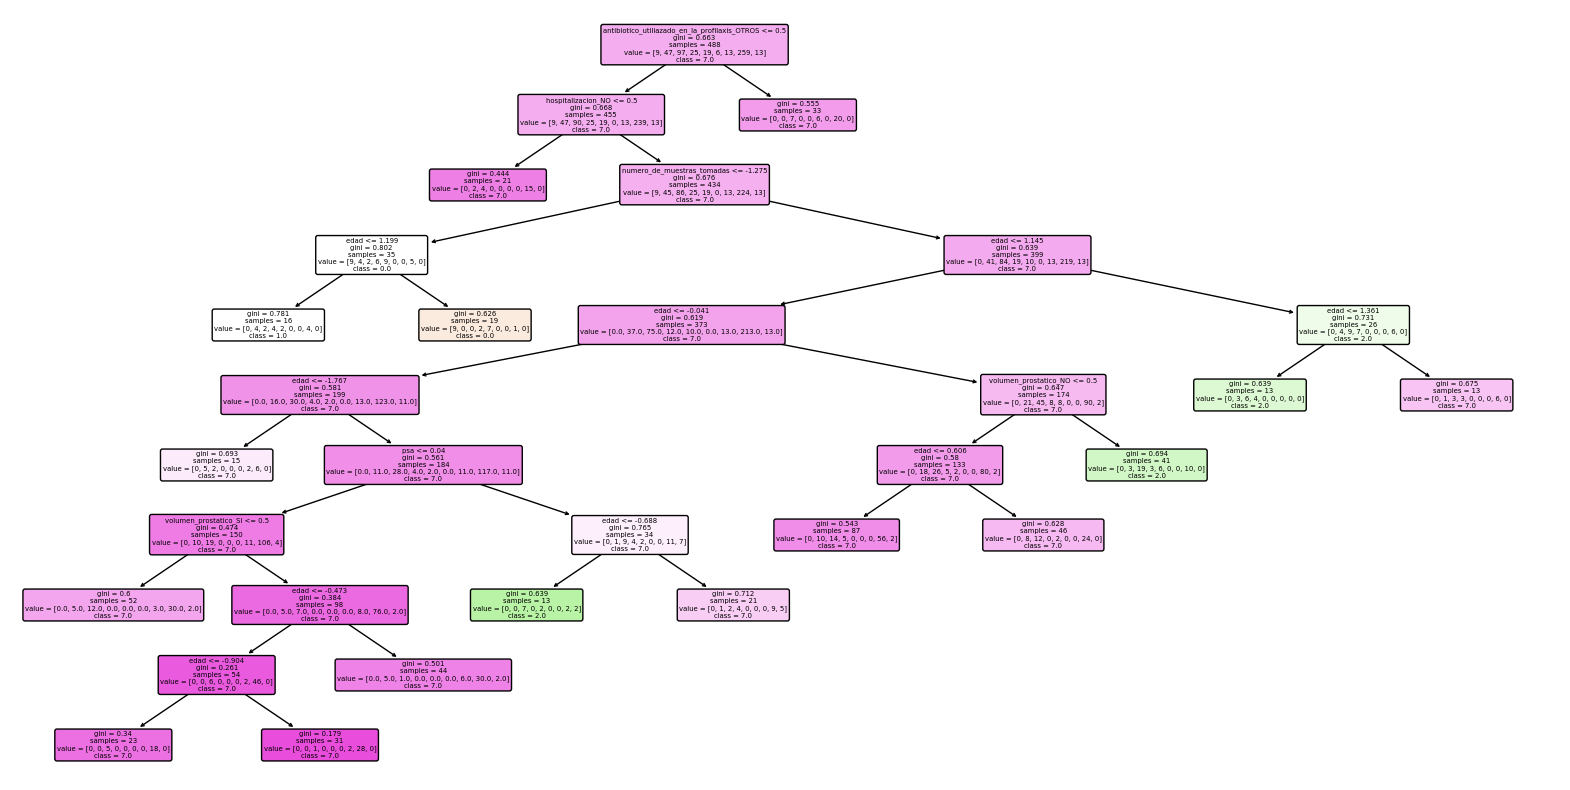

In [179]:
# Verificar las formas de los conjuntos resultantes
print("Shapes of training sets:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nShapes of testing sets:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
# Configuración de semilla
SEED = 301
np.random.seed(SEED)

def train_and_cross_validate_decision_tree(X_train, y_train, max_depth, min_samples_leaf=None):
    cv = StratifiedKFold(n_splits=10)
    if min_samples_leaf:
        modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=SEED)
    else:
        modelo = DecisionTreeClassifier(max_depth=max_depth, random_state=SEED)

    results = cross_validate(modelo, X_train, y_train, cv=cv, return_train_score=True, scoring='accuracy')
    
    for fold in range(10):
        train_score = results[f'train_score'][fold] * 100
        test_score = results[f'test_score'][fold] * 100
        print(f'Fold {fold + 1}: Árbol max_depth = {max_depth}, min_samples_leaf = {min_samples_leaf}, training = {train_score:.2f}, testing = {test_score:.2f}')
    
    avg_train_score = results['train_score'].mean() * 100
    avg_test_score = results['test_score'].mean() * 100
    print(f'Average: Árbol max_depth = {max_depth}, min_samples_leaf = {min_samples_leaf}, average training = {avg_train_score:.2f}, average testing = {avg_test_score:.2f}')
    
    return max_depth, min_samples_leaf, avg_train_score, avg_test_score

# Función para realizar búsqueda de hiperparámetros
# Función para realizar búsqueda de hiperparámetros
def hyperparameter_search(X_train, y_train, espacio_de_parametros):
    buscar = GridSearchCV(DecisionTreeClassifier(random_state=SEED),
                          espacio_de_parametros,
                          cv=KFold(n_splits=5, shuffle=True))

    buscar.fit(X_train, y_train)
    resultados = pd.DataFrame(buscar.cv_results_)
    return resultados, buscar.best_params_


# Función para visualizar el árbol de decisión
# Función para visualizar el árbol de decisión
def visualize_tree(model, features, class_names=None):
    plt.figure(figsize=(20, 10))
    plot_tree(model, filled=True, rounded=True, class_names=class_names, feature_names=features)
    plt.savefig('../datasets/images/tree.png')

espacio_de_parametros = {
    'max_depth': [8, 10, 12, 15],
    'min_samples_leaf': [10, 12, 14, 16], #16, 32, 64, 128, 256
    'min_samples_split': [2, 5, 8, 10],
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7],
    'criterion': ['gini', 'entropy']
}

# Realizar búsqueda de hiperparámetros
resultados_hyperparametros, mejores_hiperparametros = hyperparameter_search(X_train, y_train, espacio_de_parametros)

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros:", mejores_hiperparametros)

# Entrenar el modelo con los mejores hiperparámetros
mejor_modelo = DecisionTreeClassifier(**mejores_hiperparametros, random_state=SEED)
mejor_modelo.fit(X_train, y_train)

# Visualizar el árbol de decisión con los mejores hiperparámetros
visualize_tree(mejor_modelo, X_train.columns, class_names=[str(i) for i in mejor_modelo.classes_])


In [180]:
# Después de ejecutar la búsqueda de hiperparámetros
# Función para realizar búsqueda de hiperparámetros


# Realizar búsqueda de hiperparámetros
resultados_hyperparametros, mejores_hiperparametros = hyperparameter_search(X_train, y_train, espacio_de_parametros)

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros:", mejores_hiperparametros)

# Mostrar resultados filtrados
resultados_filtrados = resultados_hyperparametros[['param_max_depth', 'param_min_samples_leaf', 'mean_test_score', 'std_test_score']]
# Mostrar resultados filtrados ordenados por mean_test_score de mayor a menor
resultados_filtrados_ordenados = resultados_filtrados.sort_values(by='mean_test_score', ascending=False)
print("Resultados filtrados ordenados por mean_test_score de mayor a menor:")
print(resultados_filtrados_ordenados.head(15))

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 12, 'min_samples_split': 2}
Resultados filtrados ordenados por mean_test_score de mayor a menor:
    param_max_depth param_min_samples_leaf  mean_test_score  std_test_score
263              15                     12         0.561498        0.041827
103              10                     12         0.561498        0.041827
101              10                     12         0.561498        0.041827
100              10                     12         0.561498        0.041827
262              15                     12         0.561498        0.041827
261              15                     12         0.561498        0.041827
260              15                     12         0.561498        0.041827
102              10                     12         0.561498        0.041827
180              12                     12         0.561498        0.041827
181              12                

In [134]:
# Imprimir todas las columnas disponibles
print("Columnas disponibles en resultados_hyperparametros:")
print(resultados_hyperparametros.columns)

# Imprimir los resultados sin filtrar columnas específicas
print("Resultados de búsqueda de hiperparámetros:")
print(resultados_hyperparametros.sort_values(by='mean_test_score', ascending=False))


Columnas disponibles en resultados_hyperparametros:
Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_ccp_alpha', 'param_criterion', 'param_max_depth',
       'param_min_samples_leaf', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')
Resultados de búsqueda de hiperparámetros:
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
27       0.006878      0.000467         0.004997        0.001095   
30       0.007300      0.001846         0.004801        0.000749   
33       0.007396      0.001496         0.006119        0.001435   
51       0.007446      0.001999         0.005376        0.001329   
48       0.012569      0.006540         0.006727        0.001827   
45       0.006502      0.000641         0.005997        0.001095   
39       0.006593      0.001198         

In [171]:
from sklearn.model_selection import cross_val_score
from scipy.stats import sem, t
from numpy import mean

# Utilizar validación cruzada estratificada
cv = StratifiedKFold(n_splits=10)

# Realizar validación cruzada para obtener las métricas de rendimiento
cv_scores = cross_val_score(mejor_modelo, X_train, y_train, cv=cv)

# Calcular la precisión media
mean_accuracy = mean(cv_scores) * 100
print(f"Accuracy media {mean_accuracy:.2f}")

# Calcular el intervalo de confianza
confidence = 0.95
n = len(cv_scores)
m = mean(cv_scores)
std_err = sem(cv_scores)
h = std_err * t.ppf((1 + confidence) / 2, n - 1)

# Calcular el intervalo de confianza y mostrarlo
intervalo_confianza = (m - h, m + h)
print(f"Intervalo {confidence * 100:.2f}% {intervalo_confianza}")

# Imprimir el modelo entrenado
print(mejor_modelo)



Accuracy media 53.90
Intervalo 95.00% (0.5177479548950028, 0.5602282355811876)
DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=32,
                       random_state=301)


c:\Users\ozi\ti\evstack\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


In [146]:
from sklearn.metrics import classification_report

# Entrenar el modelo con los mejores hiperparámetros
mejor_modelo = DecisionTreeClassifier(**mejores_hiperparametros, random_state=SEED)
mejor_modelo.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = mejor_modelo.predict(X_test)

# Imprimir informe de clasificación
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))


Informe de clasificación:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.00      0.00      0.00        12
         2.0       0.24      0.17      0.20        24
         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         6
         5.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00         5
         7.0       0.55      0.81      0.66        63
         8.0       0.00      0.00      0.00         1

    accuracy                           0.48       114
   macro avg       0.09      0.11      0.09       114
weighted avg       0.36      0.48      0.40       114



c:\Users\ozi\ti\evstack\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ozi\ti\evstack\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ozi\ti\evstack\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ozi\ti\evstack\lib\site-packages\sklearn\m